Forme y : [0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1
 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1
 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1
 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1
 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1]


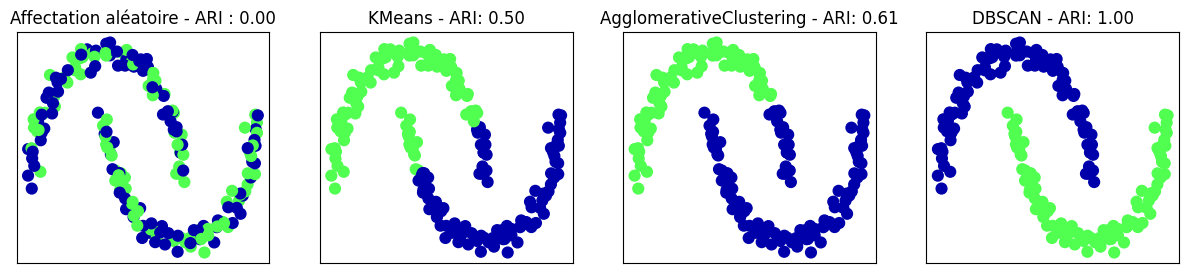

In [6]:
%matplotlib inline
# On utilise les deux métriques : 
# - ARI : adjusted rand index [ indice aléatoire ajusté ]
# - NMI : normalized mutual information [ information mutuelle normalisée ]
# pour mesurer le degré de correspondance entre la sortie produite par un algo de clustering et une partition
# de données.

import matplotlib.pyplot as plt
import numpy as np
import mglearn

from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.cluster import adjusted_rand_score


X,y = make_moons(n_samples=200, noise=0.05, random_state=0)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1,4, figsize=(15,3), subplot_kw={'xticks':(), 'yticks':()})
algorithmes = [KMeans(n_clusters=2, n_init=10), AgglomerativeClustering(n_clusters=2), DBSCAN()]

random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

print("Forme y : {}".format(y))

axes[0].scatter(X_scaled[:,0],X_scaled[:,1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Affectation aléatoire - ARI : {:.2f}".format(adjusted_rand_score(y,random_clusters)))

for ax, algorithmes in zip(axes[1:], algorithmes):
    clusters = algorithmes.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0],X_scaled[:,1],c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithmes.__class__.__name__, adjusted_rand_score(y,clusters)))

# Pour chaque point d'un cluster, on évalue sa correspondance avec sa destination
# Les points du cluster généré aléatoirement appartiennent indifféremment à l'une ou l'autre classe 0 ou 1
# La distribution des points dans les clusters trouvés algorithmiquement est de la gauche vers la droite, de plus
# en plus conforme à la réalité (y)

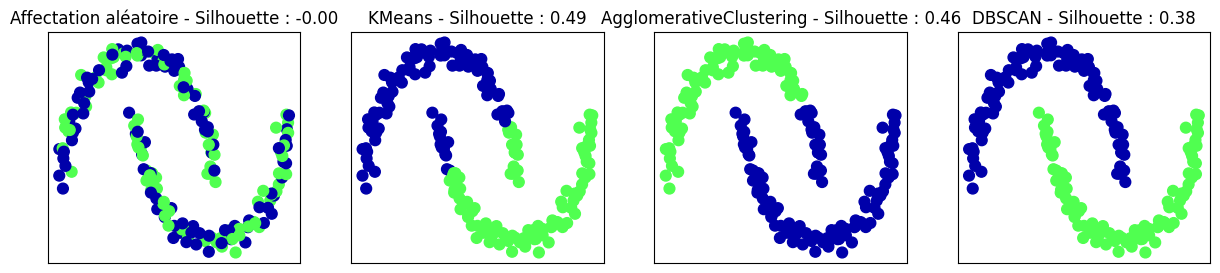

In [10]:
# La métrique "coefficient de silhouette" permet d'analyser la compacité des clusters.
from sklearn.metrics.cluster import silhouette_score

fig, axes = plt.subplots(1,4, figsize=(15,3), subplot_kw={'xticks':(), 'yticks':()})

algorithmes = [KMeans(n_clusters=2, n_init=10), AgglomerativeClustering(n_clusters=2), DBSCAN()]

axes[0].scatter(X_scaled[:,0],X_scaled[:,1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Affectation aléatoire - Silhouette : {:.2f}".format(silhouette_score(X_scaled,random_clusters)))

for ax, algorithmes in zip(axes[1:], algorithmes):
    clusters = algorithmes.fit_predict(X_scaled)
    ax.scatter(X_scaled[:,0],X_scaled[:,1],c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - Silhouette : {:.2f}".format(algorithmes.__class__.__name__, silhouette_score(X_scaled,clusters)))
    
    # Le meilleure compacité est obtenue par l'algorithme en k-moyenne.

In [16]:
# La meilleure manière de savoir si le cluster possède une sémantique dans le contexte de la recherche reste
# d'en faire l'analyse manuelle

# En considérant les données obtenues par l'analyse des composantes principales
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

mask = np.zeros(people.target.shape, dtype=np.bool_)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1 

X_people = people.data[mask]
y_people = people.target[mask]

pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [23]:
# DBSCAN
# - 1 est considéré comme du bruit, le premier cluster est étiqueté 0

# Avec les paramètres par défaut
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Paramètres par défaut - Clusters : {}\n".format(np.unique(labels)))

# Avec un nombre d'échantillon par cluster min de 3 : 
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print("Minimum de 3 échantillons par cluster - Clusters : {}\n".format(np.unique(labels)))

# En augmentant epsilon à 15
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Minimum de 3 échantillons par cluster et eps à 15 - Clusters : {}\n".format(np.unique(labels)))

print("Distribution [ bruit, cluster ] : {}".format(np.bincount(labels+1)))

Paramètres par défaut - Clusters : [-1]

Minimum de 3 échantillons par cluster - Clusters : [-1]

Minimum de 3 échantillons par cluster et eps à 15 - Clusters : [-1  0]

Distribution [ bruit, cluster ] : [  37 2026]


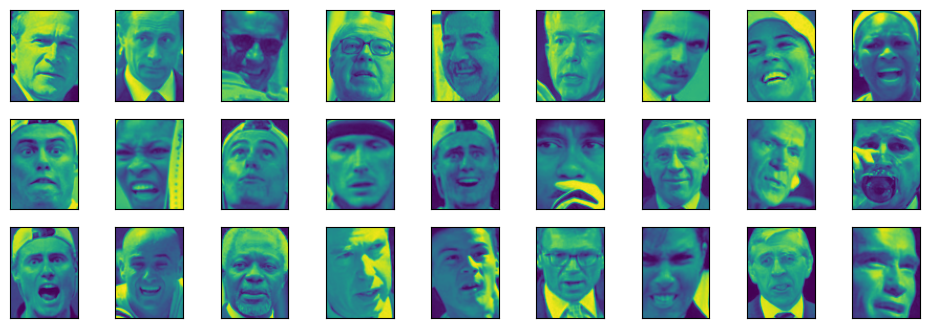

In [27]:
# Points qui correspondent à du bruit
noise = X_people[labels==-1]
fig,axes = plt.subplots(3,9, subplot_kw={'xticks':(),'yticks':()}, figsize=(12,4))

X_people = people.data[mask]
y_people = people.target[mask]
image_shape = people.images[0].shape

for image, ax in zip (noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

# Les images montrent des vêtements ou sont mal cadrées. Ces images peuvent être considérées comme des données
# aberrantes

In [29]:
# En diminuant la valeur d'eps pour éviter d'avoir un gros cluster :
for eps in [1,3,5,7,9,11,13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Nombre de clusters : {}".format(len(np.unique(labels))))
    print("Taille des clusters : {}".format(np.bincount(labels+1)))
    


eps=1
Nombre de clusters : 1
Taille des clusters : [2063]

eps=3
Nombre de clusters : 1
Taille des clusters : [2063]

eps=5
Nombre de clusters : 2
Taille des clusters : [2059    4]

eps=7
Nombre de clusters : 8
Taille des clusters : [1954   75    4   14    6    4    3    3]

eps=9
Nombre de clusters : 3
Taille des clusters : [1199  861    3]

eps=11
Nombre de clusters : 2
Taille des clusters : [ 403 1660]

eps=13
Nombre de clusters : 2
Taille des clusters : [ 119 1944]


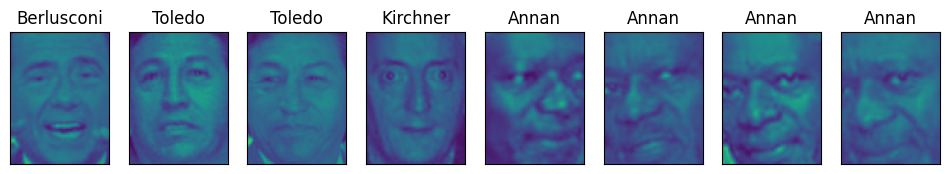

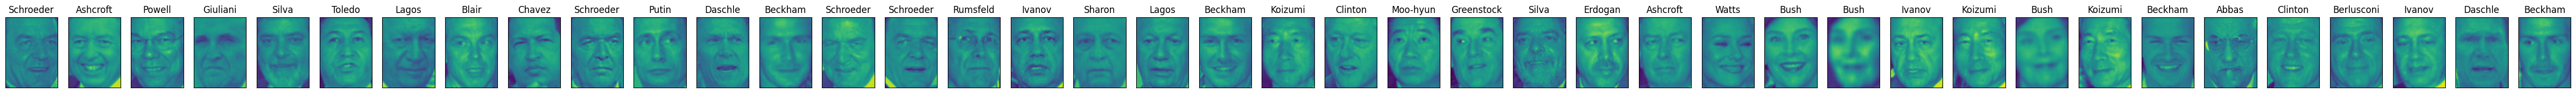

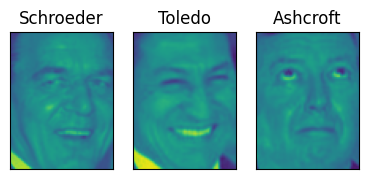

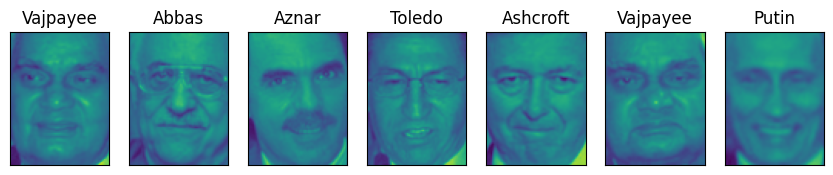

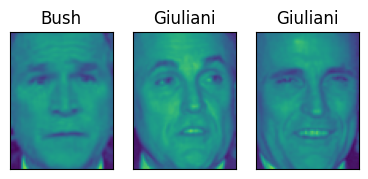

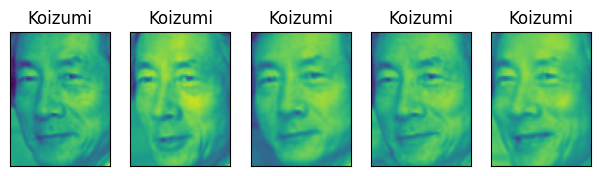

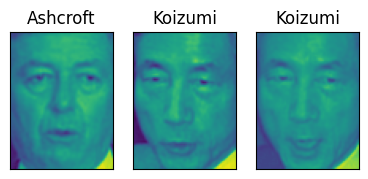

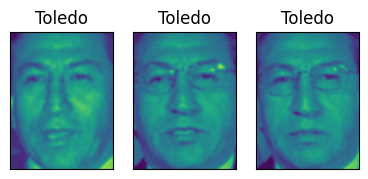

In [31]:
# images des clusters pour eps = 7
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_people)

for cluster in range(max(labels)+1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1,n_images, figsize=(n_images*1.5,4), subplot_kw={'xticks':(),'yticks':()})
    for image, label, ax in zip(X_people[mask],y_people[mask], axes):
        ax.imshow(image.reshape(image_shape),vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])

In [34]:
# Analyse du clustering k-moyenne
km = KMeans(n_clusters=10, random_state=0, n_init=10)
labels_km = km.fit_predict(X_pca)
print("Taille des clusters pour une recherche de 10 clusters : \n{}".format(np.bincount(labels_km)))

Taille des clusters pour une recherche de 10 clusters : 
[ 70 198 139 109 196 351 207 424 180 189]


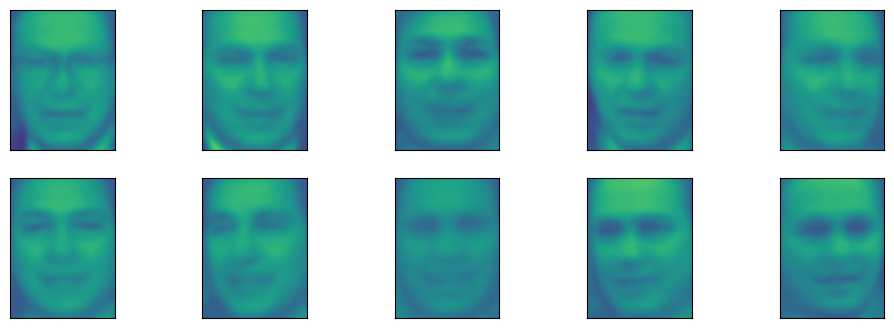

In [40]:
# Ce qui donne comme images : 
fig, axes = plt.subplots(2,5, subplot_kw={'xticks':(), 'yticks':()}, figsize=(12,4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape), vmin=0,vmax=1)
    
# On dirait que l'algo a "essayé de trouver" les orientations des visages

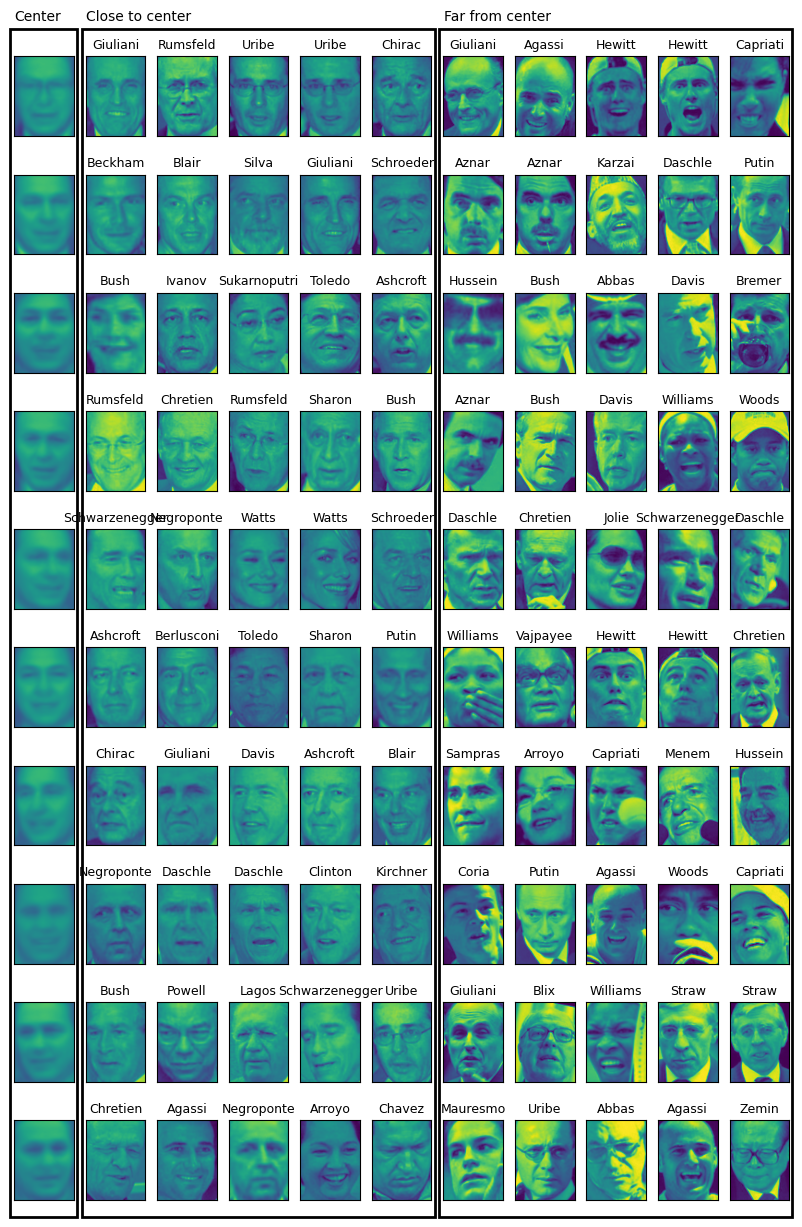

In [43]:
# Vue des 5 images les plus proches du centre et des 5 images les plus éloignées.
mglearn.plots.plot_kmeans_faces(km,pca, X_pca, X_people, y_people, people.target_names)

In [47]:
# Analyse avec clustering agglomératif
agglo = AgglomerativeClustering(n_clusters=10)
labels_agg = agglo.fit_predict(X_pca)
print("Taille des clusters de l'algo clustering agglomératif : \n{}".format(np.bincount(labels_agg)))

Taille des clusters de l'algo clustering agglomératif : 
[264 100 275 553  49  64 546  52  51 109]


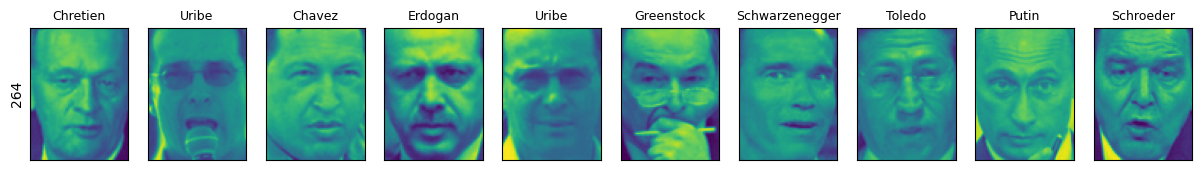

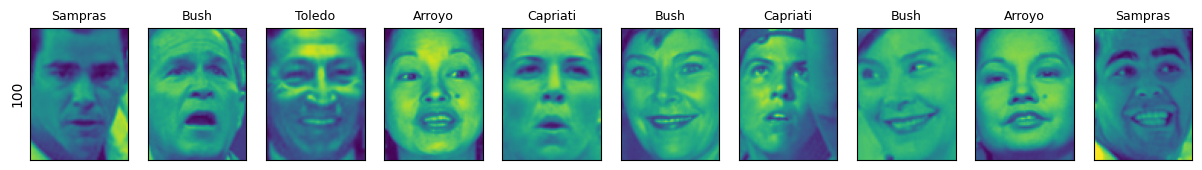

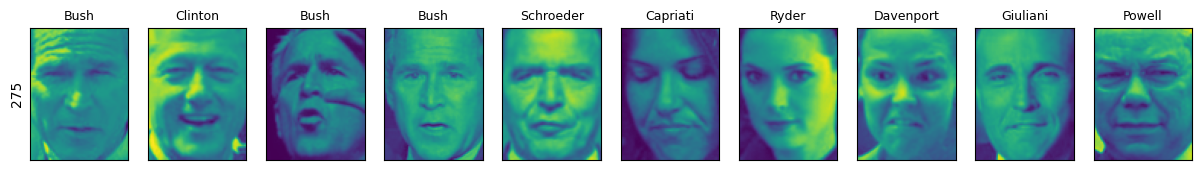

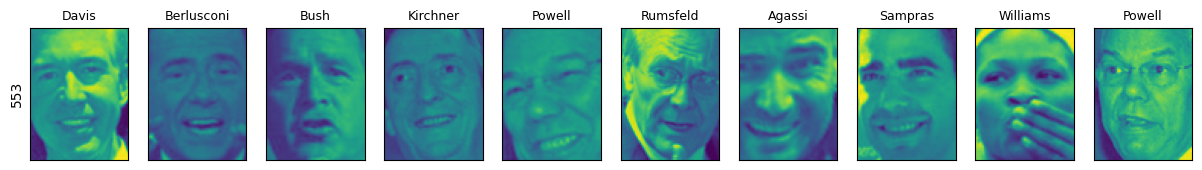

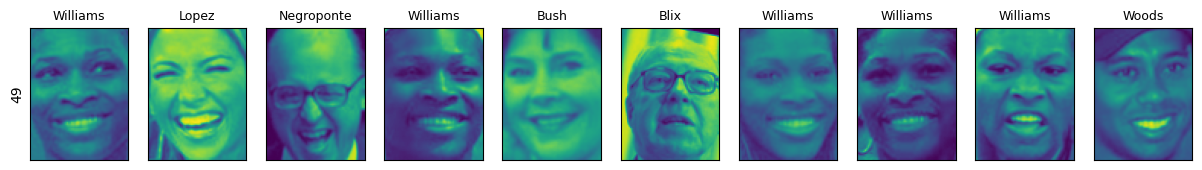

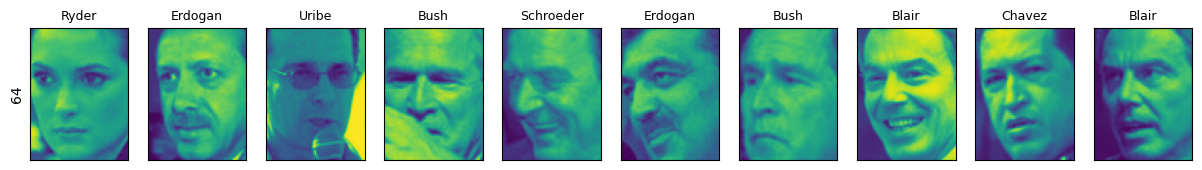

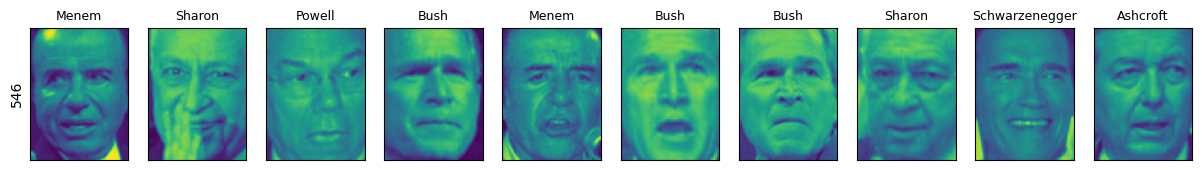

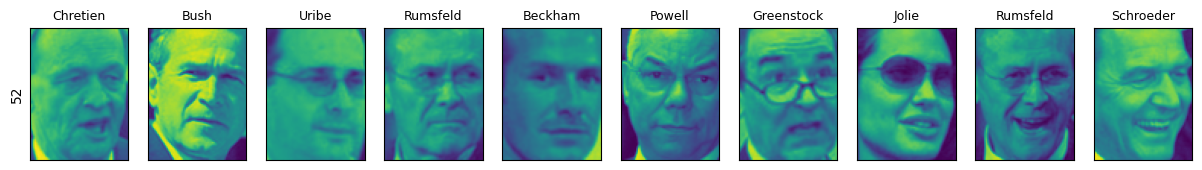

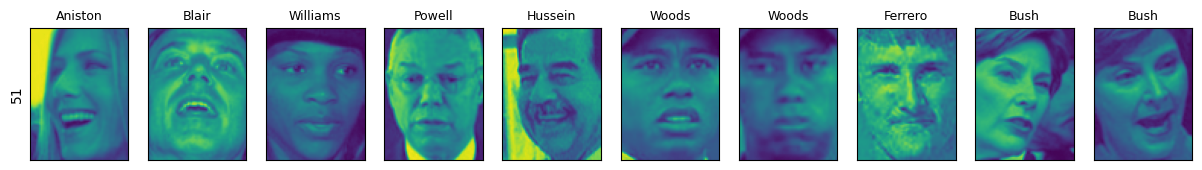

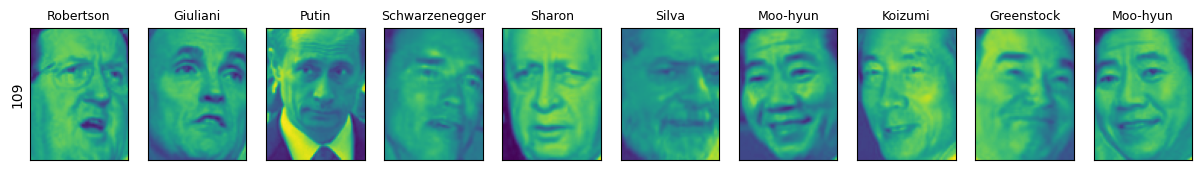

In [53]:
# Examples d'images présents dans les clusters trouvés : 
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1,10, subplot_kw={'xticks':(),'yticks':()},figsize=(15,8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})

# Avec 10 clusters, on ne distingue pas suffisamment de sémantique, on est trop facilement noyé dans le bruit 
# ou les aberrations.

Taille des clusters de l'algo clustering agglomératif : 
[139  35  23   2 111  39 106  33   5 161  60  41  70  17  30  20 134  40
  23  38  56 264   4  35  44  16  29 135  25  37  42  34   3  17  31   3
  21  27  76  37]


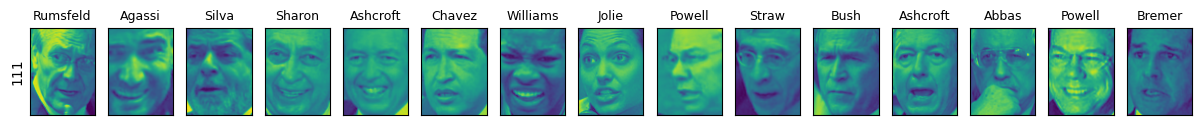

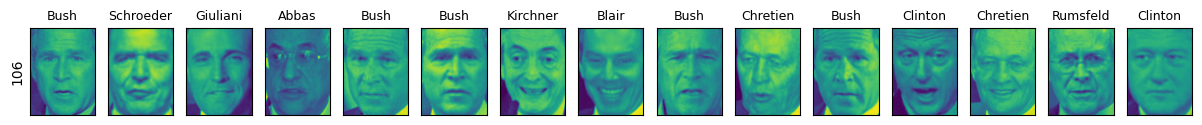

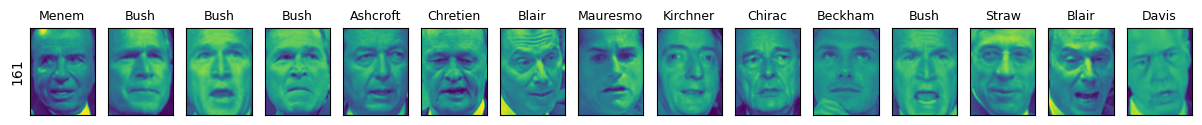

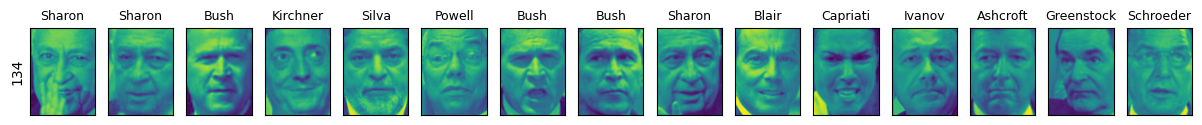

In [58]:
# en considérant 40 clusters plutôt que 10 :

agglo = AgglomerativeClustering(n_clusters=40)
labels_agg = agglo.fit_predict(X_pca)
print("Taille des clusters de l'algo clustering agglomératif : \n{}".format(np.bincount(labels_agg)))

n_clusters = 10
for cluster in [4,6,9,16]:
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1,15, subplot_kw={'xticks':(),'yticks':()},figsize=(15,8))

    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask], labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1], fontdict={'fontsize': 9})

